In [60]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
cardiac_features = pd.read_csv('ECG_Cardiac_Features.csv')
cardiac_features.drop(columns=['Patient_ID'], inplace=True)
fourier_features = pd.read_csv('ECG_Fourier_Transform_Features.csv')
fourier_features.drop(columns=['Patient_ID', 'Label'], inplace=True)
time_features = pd.read_csv('ECG_Time_Features_100.csv')

hilbert_features = pd.read_csv('ECG_Hilbert_Features.csv')

merged_features = pd.merge(cardiac_features, fourier_features, on='ecg_id', how='inner')
merged_features = pd.merge(merged_features, time_features, on='ecg_id', how='inner')
merged_features = pd.merge(merged_features, hilbert_features, on='ecg_id', how='inner')

merged_features.head()

,ecg_id,Label,Heart Rate,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_pNN50,QRS_duration,PR_duration,RR Interval Mean,...,mean_amplitude_max,mean_amplitude_std,std_amplitude_mean,std_amplitude_max,std_amplitude_std,qrs_amplitude_mean,qrs_amplitude_max,qrs_amplitude_std,Phase Locking Value,Phase Duration
0,1,NORM,63.847119,940.000000,17.320508,22.627417,0.000000,141.714286,127.333333,940.000000,...,0.141135,0.018233,0.096241,0.104166,0.006757,0.179152,0.219571,0.019721,0.999996,7.034
1,2,NORM,47.838174,1258.285714,82.836615,54.546616,42.857143,174.285714,152.000000,1258.285714,...,0.176487,0.017505,0.114857,0.143277,0.016411,0.206247,0.232510,0.022552,0.998820,6.782
2,3,NORM,63.822587,940.444444,20.019435,17.606817,0.000000,130.750000,114.500000,940.444444,...,0.126937,0.006781,0.121469,0.132664,0.007027,0.216436,0.234370,0.018504,1.000000,7.134
3,4,NORM,75.152692,800.545455,45.511237,35.185224,9.090909,160.727273,110.000000,800.545455,...,0.163980,0.008008,0.127177,0.147120,0.009429,0.230262,0.250277,0.014107,0.999995,7.474
4,5,NORM,66.456900,905.200000,51.018080,57.271284,50.000000,NaN,122.000000,905.200000,...,0.094065,0.004519,0.077827,0.088043,0.004950,0.145751,0.165159,0.013266,0.999992,7.180


In [62]:
print(merged_features.columns)
print(merged_features.shape)

Index(['ecg_id', 'Label', 'Heart Rate', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD',
       'HRV_pNN50', 'QRS_duration', 'PR_duration', 'RR Interval Mean',
       ...
       'mean_amplitude_max', 'mean_amplitude_std', 'std_amplitude_mean',
       'std_amplitude_max', 'std_amplitude_std', 'qrs_amplitude_mean',
       'qrs_amplitude_max', 'qrs_amplitude_std', 'Phase Locking Value',
       'Phase Duration'],
      dtype='object', length=151)
(20773, 151)


In [63]:
feature_columns = [col for col in merged_features.columns if col not in ['ecg_id', 'Label']]

for col in feature_columns:
    print(f"{col}: {merged_features[col].isna().sum()} missing values")

Heart Rate: 1 missing values
HRV_MeanNN: 0 missing values
HRV_SDNN: 0 missing values
HRV_RMSSD: 0 missing values
HRV_pNN50: 0 missing values
QRS_duration: 2807 missing values
PR_duration: 3215 missing values
RR Interval Mean: 0 missing values
RR Interval SD: 0 missing values
RR Interval RMSSD: 0 missing values
RR Interval Min: 0 missing values
RR Interval Max: 0 missing values
QT Interval Mean: 197 missing values
QT Interval SD: 197 missing values
ST Segment Amplitude Mean: 185 missing values
ST Segment Amplitude SD: 185 missing values
ST Segment Duration Mean: 185 missing values
ST Segment Duration SD: 185 missing values
Dominant Frequency: 0 missing values
Frequency Power Sum: 0 missing values
Mean Frequency: 0 missing values
Spectral Entropy: 0 missing values
MFCC_1: 0 missing values
MFCC_2: 0 missing values
MFCC_3: 0 missing values
MFCC_4: 0 missing values
MFCC_5: 0 missing values
MFCC_6: 0 missing values
MFCC_7: 0 missing values
MFCC_8: 0 missing values
MFCC_9: 0 missing values
MF

In [64]:
classes = list(merged_features['Label'].unique())

feature_columns = [col for col in merged_features.columns if col not in ['ecg_id', 'Label']]

for col in feature_columns:
    merged_features[col] = merged_features.groupby('Label')[col].transform(
        lambda x: x.fillna(x.mean())
    )

In [65]:
feature_columns = [col for col in merged_features.columns if col not in ['ecg_id', 'Label']]

for col in feature_columns:
    print(f"{col}: {merged_features[col].isna().sum()} missing values")

Heart Rate: 0 missing values
HRV_MeanNN: 0 missing values
HRV_SDNN: 0 missing values
HRV_RMSSD: 0 missing values
HRV_pNN50: 0 missing values
QRS_duration: 0 missing values
PR_duration: 0 missing values
RR Interval Mean: 0 missing values
RR Interval SD: 0 missing values
RR Interval RMSSD: 0 missing values
RR Interval Min: 0 missing values
RR Interval Max: 0 missing values
QT Interval Mean: 0 missing values
QT Interval SD: 0 missing values
ST Segment Amplitude Mean: 0 missing values
ST Segment Amplitude SD: 0 missing values
ST Segment Duration Mean: 0 missing values
ST Segment Duration SD: 0 missing values
Dominant Frequency: 0 missing values
Frequency Power Sum: 0 missing values
Mean Frequency: 0 missing values
Spectral Entropy: 0 missing values
MFCC_1: 0 missing values
MFCC_2: 0 missing values
MFCC_3: 0 missing values
MFCC_4: 0 missing values
MFCC_5: 0 missing values
MFCC_6: 0 missing values
MFCC_7: 0 missing values
MFCC_8: 0 missing values
MFCC_9: 0 missing values
MFCC_10: 0 missing v

In [66]:
X = merged_features[feature_columns]
y = merged_features['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Accuracy: 0.6155327342747111


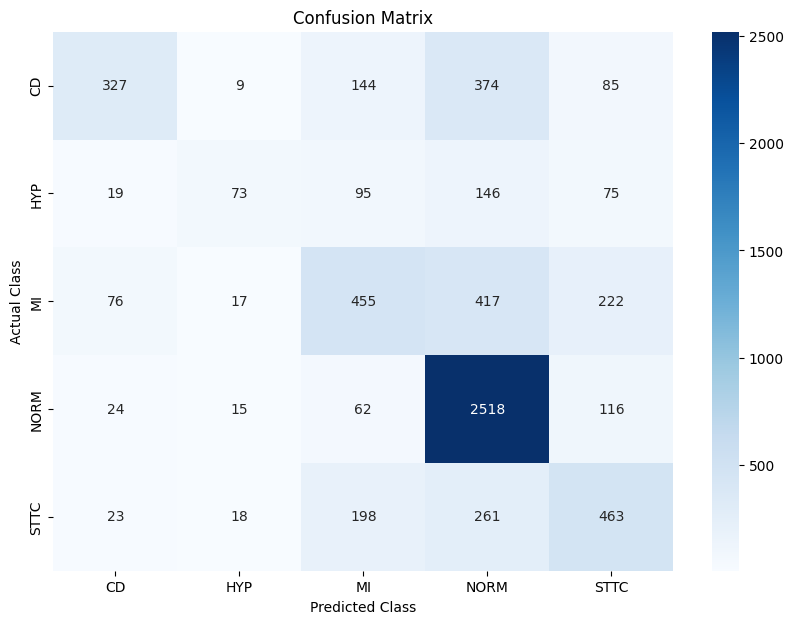

In [71]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy_rf)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
labels = sorted(set(y_test) | set(y_pred))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Adding labels, title, and formatting
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix")
plt.show()

In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          CD       0.70      0.35      0.46       939
         HYP       0.55      0.18      0.27       408
          MI       0.48      0.38      0.43      1187
        NORM       0.68      0.92      0.78      2735
        STTC       0.48      0.48      0.48       963

    accuracy                           0.62      6232
   macro avg       0.58      0.46      0.48      6232
weighted avg       0.60      0.62      0.59      6232



In [73]:
feature_importances = rf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

top_50_features = importance_df.head(50)

# Display top 509 features
print(top_50_features)

                                               Feature  Importance
35                              value__quantile__q_0.9    0.022739
14                           ST Segment Amplitude Mean    0.017164
12                                    QT Interval Mean    0.016322
66                    value__ratio_beyond_r_sigma__r_3    0.014142
13                                      QT Interval SD    0.013132
67                  value__ratio_beyond_r_sigma__r_0.5    0.013081
6                                          PR_duration    0.012826
21                                    Spectral Entropy    0.011549
44   value__change_quantiles__f_agg_"var"__isabs_Tr...    0.011453
111                   value__fourier_entropy__bins_100    0.011267
36                              value__quantile__q_0.6    0.010492
64                          value__benford_correlation    0.010305
5                                         QRS_duration    0.010263
99               value__partial_autocorrelation__lag_4    0.01

In [70]:
# encoder = OneHotEncoder(sparse_output=False)
# y_train_onehot = encoder.fit_transform(y_train.values.reshape(-1, 1))
# y_test_onehot = encoder.transform(y_test.values.reshape(-1, 1))

# X_train_lstm = np.expand_dims(X_train, axis=1)  # Adding a timestep dimension
# X_test_lstm = np.expand_dims(X_test, axis=1)

# # Define the LSTM model
# lstm_model = Sequential([
#     Input(shape=(1, X_train.shape[1])),
#     LSTM(128, return_sequences=True),
#     Dropout(0.4),
#     LSTM(64),
#     Dropout(0.4),
#     Dense(y_train_onehot.shape[1], activation='softmax')
# ])

# lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# lstm_model.fit(X_train_lstm, y_train_onehot, epochs=100, batch_size=32, validation_data=(X_test_lstm, y_test_onehot))

# lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_onehot, verbose=0)
# print(f"LSTM Test Accuracy: {lstm_accuracy:.2f}")